Загружаем библиотеки:

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import os

pd.set_eng_float_format(accuracy=4, use_eng_prefix=True)

DATA_PATH = 'Датасеты'
TERMINAL_DATA_PATH = os.path.join(DATA_PATH, 'terminal_data_hackathon v4.xlsx')
TIMES_DATA_PATH = os.path.join(DATA_PATH, 'times v4.csv')

Читаем местоположение терминалов:

In [38]:
points = pd.read_excel(TERMINAL_DATA_PATH, sheet_name='TIDS')
tid_to_ind = {tid: i for i, tid in enumerate(points.TID)}
terminals_num = len(points)
points.head()

,TID,longitude,latitude
0,692835,37.6463,55.7421
1,698656,37.6661,55.7312
2,686168,37.6750,55.7270
3,679671,37.6697,55.7068
4,682180,37.5964,55.7112


Читаем пополнения терминалов за каждый день, вычисляем остатки на конец дня (если не забирать деньги):

In [39]:
columns = ['TID', 'start_value'] + [f'day {i + 1}' for i in range(91)]
incomes = pd.read_excel(TERMINAL_DATA_PATH, sheet_name='Incomes', names=columns)
add_columns = [f'remains {i + 1}' for i in range(91)]
incomes[add_columns] = incomes[columns[1:]].values.cumsum(axis=1)[:, 1:]
incomes.head()

,TID,start_value,day 1,day 2,day 3,day 4,day 5,day 6,day 7,day 8,...,remains 82,remains 83,remains 84,remains 85,remains 86,remains 87,remains 88,remains 89,remains 90,remains 91
0,406136,160000,90000,105000,99000,107000,110000,60000,75000,89000,...,7841000,7919000,7919000,8084000,8084000,8273000,8379000,8473000,8548000,8622000
1,406139,387000,103000,206000,168000,124000,78000,165000,164000,174000,...,12998000,13151000,13302000,13459000,13665000,13847000,13970000,14108000,14220000,14399000
2,406145,287000,143000,136000,124000,117000,123000,140000,139000,138000,...,11050000,11150000,11329000,11498000,11616000,11734000,11848000,11976000,12097000,12221000
3,406148,355000,50000,73000,53000,65000,75000,100000,53000,52000,...,5844000,5899000,5964000,6049000,6144000,6212000,6274000,6274000,6392000,6462000
4,406180,597000,96000,82000,71000,72000,86000,55000,55000,75000,...,6842000,6898000,6968000,7027000,7132000,7202000,7279000,7366000,7425000,7480000


In [40]:
incomes['remains 91'].describe()

count      1.6300k
mean       5.4406M
std        3.7562M
min      286.0000k
25%        3.3160M
50%        4.8195M
75%        6.5542M
max       67.5760M
Name: remains 91, dtype: float64

In [41]:
terms = points.set_index('TID').join(incomes.set_index('TID')).reset_index()
terms.head()

,TID,longitude,latitude,start_value,day 1,day 2,day 3,day 4,day 5,day 6,...,remains 82,remains 83,remains 84,remains 85,remains 86,remains 87,remains 88,remains 89,remains 90,remains 91
0,692835,37.6463,55.7421,98000,0,35000,12000,20000,0,0,...,1190000,1190000,1190000,1210000,1218000,1236000,1236000,1279000,1279000,1306000
1,698656,37.6661,55.7312,291000,43000,36000,32000,0,36000,38000,...,3043000,3078000,3102000,3132000,3172000,3202000,3237000,3282000,3326000,3361000
2,686168,37.6750,55.7270,198000,23000,0,18000,10000,10000,0,...,1407000,1407000,1417000,1437000,1459000,1459000,1482000,1507000,1519000,1537000
3,679671,37.6697,55.7068,309000,40000,75000,61000,41000,67000,51000,...,5449000,5509000,5590000,5657000,5698000,5749000,5749000,5749000,5749000,5749000
4,682180,37.5964,55.7112,719000,122000,120000,141000,162000,134000,135000,...,8699000,8760000,8820000,8889000,8940000,9054000,9184000,9234000,9304000,9362000


Визуализируем точки на карте:

(array([1.295e+03, 2.930e+02, 3.400e+01, 5.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00e-06, 7.40e+04, 1.48e+05, 2.22e+05, 2.96e+05, 3.70e+05,
        4.44e+05, 5.18e+05, 5.92e+05, 6.66e+05, 7.40e+05]),
 <BarContainer object of 10 artists>)

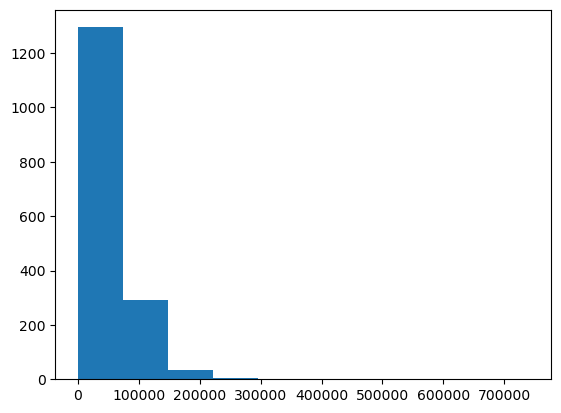

In [65]:
plt.hist(color_vals)

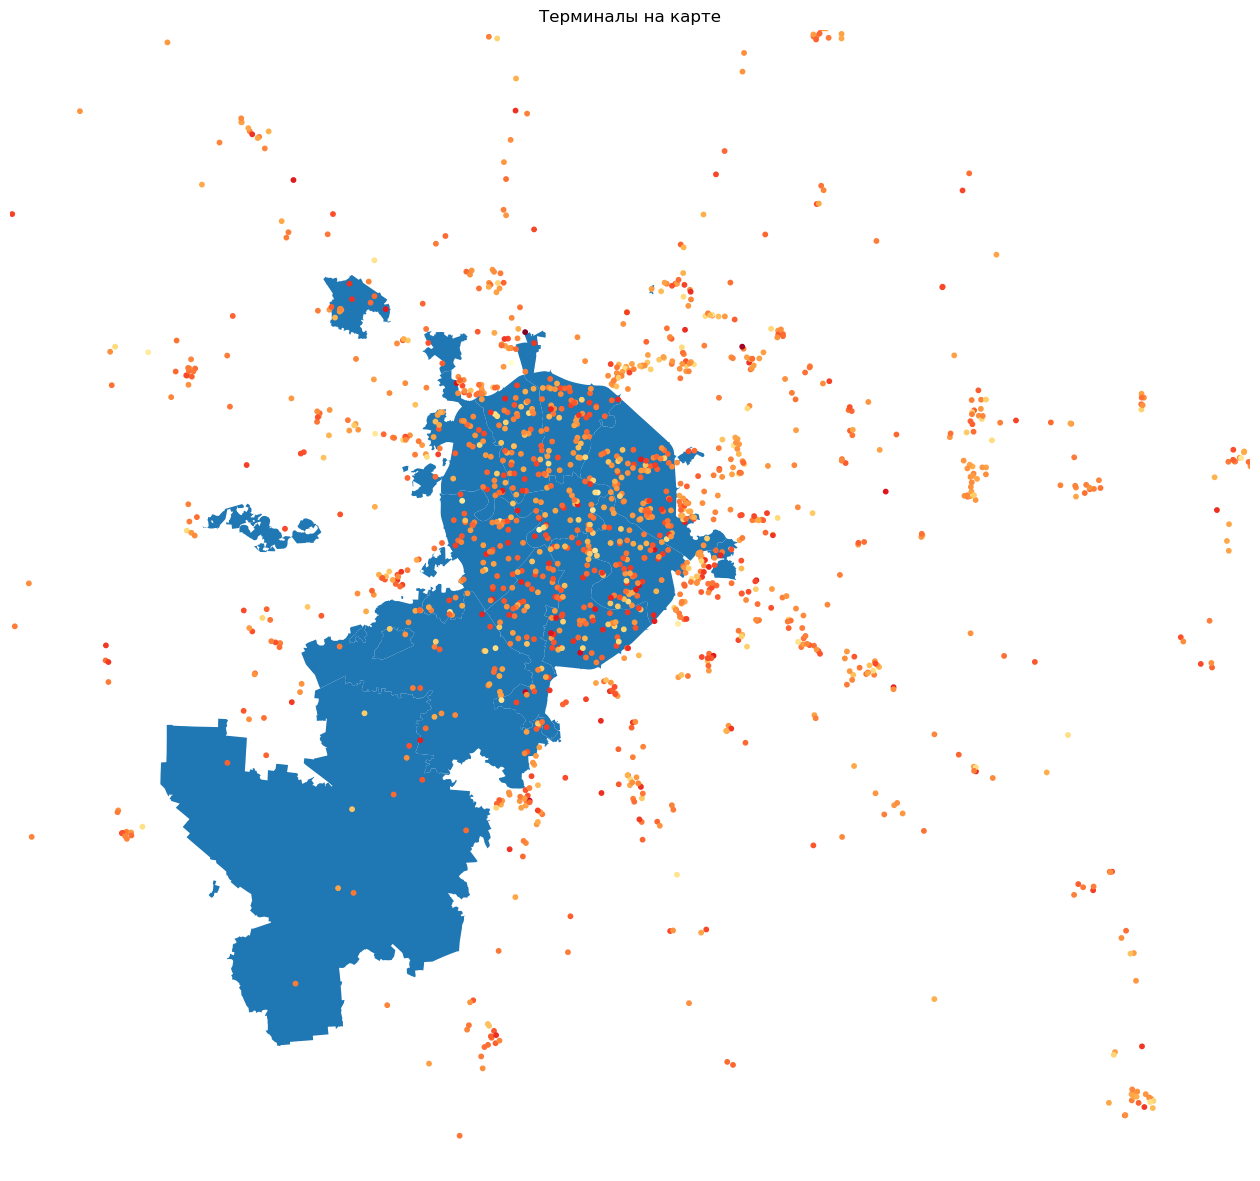

In [68]:
# TODO: СДЕЛАТЬ НОРМАЛЬНО
moscow = gpd.read_file("ao-shape.zip")

fig, ax = plt.subplots(figsize=(16, 16))
moscow.plot(ax=ax)
color_vals = terms['remains 91'] # np.median(terms[columns[2:]].values, axis=1).clip(1e-6)
ax.scatter(terms['longitude'], terms['latitude'], s=10, c=color_vals,
            norm=colors.LogNorm(vmin=color_vals.min(), vmax=color_vals.max()), cmap='YlOrRd')
plt.xlim((36.5, 39))
plt.ylim((55, 56.3))
plt.axis('off')
plt.title('Терминалы на карте')
plt.show()

Время на дорогу между терминалами:

In [43]:
times = pd.read_csv(TIMES_DATA_PATH)
times['Origin_index'] = times['Origin_tid'].apply(lambda tid: tid_to_ind[tid])
times['Destination_index'] = times['Destination_tid'].apply(lambda tid: tid_to_ind[tid])
times.head()

,Origin_tid,Destination_tid,Total_Time,Origin_index,Destination_index
0,636538,683103,15.3200,1568,122
1,636538,634763,16.2000,1568,93
2,636538,683128,16.2700,1568,94
3,636538,683789,16.7700,1568,121
4,636538,634709,17.6700,1568,117


In [44]:
times['Total_Time'].describe()

count     2.6553M
mean      67.4892
std       40.5600
min        0.0000
25%       36.3500
50%       58.5500
75%       91.0500
max      327.1900
Name: Total_Time, dtype: float64

Матрица времени:

In [45]:
t_pairs = times[['Origin_index', 'Destination_index']].values
time_matrix = np.zeros((terminals_num, terminals_num))
time_matrix[t_pairs[:, 0], t_pairs[:, 1]] = times['Total_Time']